# README
## hintになりそうカーネル
- https://www.kaggle.com/gunesevitan/advanced-feature-engineering-tutorial-with-titanic
    - cabinの考察

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train_org = pd.read_csv('input/titanic/train.csv')
test_org = pd.read_csv('input/titanic/test.csv')

train = train_org[[
    # 'PassengerId',
    'Survived',
    'Pclass',
    'Name',
    'Sex',
    # 'Age',
    'SibSp',
    'Parch',
    # 'Ticket',
    'Fare',
    # 'Cabin',
    'Embarked'
]].copy()

test = test_org[[
    'PassengerId',  # 男女別に予測値を出してから結合するための情報として使う
    'Pclass',
    'Name',
    'Sex',
    # 'Age',
    'SibSp',
    'Parch',
    # 'Ticket',
    'Fare',
    # 'Cabin',
    'Embarked'
]].copy()

# 男女別でFareを観察

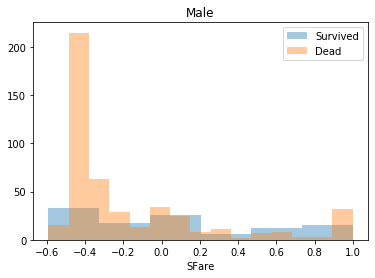

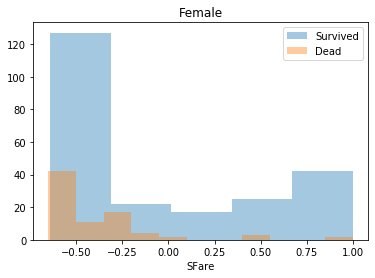

In [16]:
# Fareによる違い
male = train_org[train_org['Sex']=='male'][['Survived','Fare']].copy()

male['SFare'] = StandardScaler().fit_transform(male[['Fare']])

sns.distplot(male[male['Survived']==1]['SFare'].clip(upper=1), kde=False, label='Survived')
sns.distplot(male[male['Survived']==0]['SFare'].clip(upper=1), kde=False, label='Dead')

plt.legend()
plt.title('Male')
plt.show()


female = train_org[train_org['Sex']=='female'][['Survived','Fare']].copy()
female['SFare'] = StandardScaler().fit_transform(female[['Fare']])

sns.distplot(female[female['Survived']==1]['SFare'].clip(upper=1), kde=False, label='Survived')
sns.distplot(female[female['Survived']==0]['SFare'].clip(upper=1), kde=False, label='Dead')

plt.legend()
plt.title('Female')
plt.show()


# 前処理

In [14]:
# データが小さいことに加え、すぐに試せることを重視して、すべての前処理を1つの関数にしている
def preprocess(train_org, test_org):
    train = train_org.copy()
    test = test_org.copy()

    # Embarked
    train['Embarked'] = train['Embarked'].fillna('S')
    embarked_dict = {'S': 0, 'C': 1, 'Q': 2}
    train['Embarked'] = train['Embarked'].map(embarked_dict)
    test['Embarked'] = test['Embarked'].map(embarked_dict)

    # Family
    train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
    train.drop(columns=['SibSp', 'Parch'], inplace=True)
    test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
    test.drop(columns=['SibSp', 'Parch'], inplace=True)

    # IsMaster
    train['Title'] = train['Name'].str.extract(r',\s([a-zA-Z]+)\.')
    train['IsMaster'] = (train['Title'] == 'Master').astype(int)
    train.drop(columns=['Name', 'Title'], inplace=True)
    test['Title'] = test['Name'].str.extract(r',\s([a-zA-Z]+)\.')
    test['IsMaster'] = (test['Title'] == 'Master').astype(int)
    test.drop(columns=['Name', 'Title'], inplace=True)

    # 性別でDF分割
    train_male = train[train['Sex'] == 'male']
    X_train_male = train_male.drop(columns=['Sex', 'Survived'])
    y_train_male = train_male['Survived']

    train_female = train[train['Sex'] == 'female'].drop(columns=['IsMaster'])
    X_train_female = train_female.drop(columns=['Sex', 'Survived'])
    y_train_female = train_female['Survived']

    X_test_male = test[test['Sex'] == 'male'].drop(columns=['Sex'])
    X_test_female = test[test['Sex'] == 'female'].drop(columns=['Sex']).drop(
        columns=['IsMaster'])


    return X_train_male, y_train_male, \
        X_train_female, y_train_female, \
        X_test_male, X_test_female


X_train_male, y_train_male, X_train_female, y_train_female, X_test_male, X_test_female = preprocess(train, test)

X_train_male.head()

,Pclass,Fare,Embarked,FamilySize,IsMaster
0,3,7.2500,0,2,0
4,3,8.0500,0,1,0
5,3,8.4583,2,1,0
6,1,51.8625,0,1,0
7,3,21.0750,0,5,1


# Building models

In [6]:
skf = StratifiedKFold(n_splits=10, random_state=0)

In [7]:
def show_coefs_from_grid(grid, train):
    best_logreg = grid.best_estimator_.named_steps['logreg']

    for col_name, coef in zip(train.columns, best_logreg.coef_[0]):
        print(f'{coef:.4f}{col_name} + ', end='')

    intercept = best_logreg.intercept_[0]
    print(f'{intercept:.4f}')

## Male

In [8]:
pipe_male = Pipeline([('scaler', StandardScaler()),
                      ('logreg', LogisticRegression())])

param_grid_male = {'logreg__C': [10**x for x in range(-3, 3)]}

grid_male = GridSearchCV(estimator=pipe_male,
                         param_grid=param_grid_male,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

grid_male = grid_male.fit(X_train_male, y_train_male)

print(grid_male.best_params_, grid_male.best_score_)

print('Male model: ', end='')
show_coefs_from_grid(grid_male, X_train_male)

{'logreg__C': 10} 0.8457538994800693
Male model: -0.3807Pclass + 0.0475Embarked + -1.1097FamilySize + 1.1277IsMaster + -0.4080SFare + -1.7449


In [9]:
y_pred_male = grid_male.predict(X_test_male.drop(columns=['PassengerId']))
y_pred_male

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1])

## Female

In [10]:
pipe_female = Pipeline([('scaler', StandardScaler()),
                        ('logreg', LogisticRegression())])

param_grid_female = {'logreg__C': [10**x for x in range(-3, 3)]}

grid_female = GridSearchCV(estimator=pipe_female,
                           param_grid=param_grid_female,
                           scoring='accuracy',
                           cv=skf,
                           n_jobs=-1)

grid_female = grid_female.fit(X_train_female, y_train_female)

print(grid_female.best_params_, grid_female.best_score_)
print('Female model: ', end='')
show_coefs_from_grid(grid_female, X_train_female)

{'logreg__C': 0.1} 0.7961783439490446
Female model: -1.0138Pclass + 0.0562Fare + 0.2413Embarked + -0.3979FamilySize + 1.1361


In [11]:
y_pred_female = grid_female.predict(
    X_test_female.drop(columns=['PassengerId']))
y_pred_female

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

# Submission

## 男女別の予測を結合する

In [12]:
submit_male = X_test_male[['PassengerId']].copy()
submit_female = X_test_female[['PassengerId']].copy()

submit_male['Survived'] = y_pred_male
submit_female['Survived'] = y_pred_female

submit_data = pd.concat([submit_male,
                         submit_female]).sort_values('PassengerId')

submit_data.isnull().sum()

PassengerId    0
Survived       0
dtype: int64

## Age欠損 => 死亡

In [13]:
submit_data['Age'] = test_org['Age']
submit_data.loc[submit_data['Age'].isna(), 'Survived'] = 0

assert [0] == submit_data[submit_data['Age'].isnull()]['Survived'].unique()

submit_data.drop(columns=['Age'], inplace=True)
submit_data.to_csv('submission/gender_models_age_nan_is_dead.csv', index=False)

おわり